In [1]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.weightstats as smS

WMN = 'WMN'
UNKNOWN = 'UNK'
OTHER = 'Other'

AC, FB ='AC','FB'
PE, ALK = 'PE','ALK'
PVC = 'PVC'
CI, CLCI, DI, ELCI, CLDI, GI = 'CI','CLCI', 'DI', 'ELCI', 'CLDI','GI'
IRON='Iron'

MAX_PERCEN_TOSHOW = 2

MAX_PRERanges='PreMax_Range'
LBL_MAX_PRE = 'Max pressure (m)'
LBL_PRE_FLU = 'Pressure fluctuation (m)'

INSERV_PROCESS = 'In Service'
MATERIALS_PREDOMI = [AC,PVC,IRON,PE]

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,110]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,110]']

PressFluc_bins = [0,3,6,9,12,15,20,35]
PFlucRange_labels = ['(0,3]','(3,6]','(6,9]','(9,12]','(12,15]','(15,20]','(20,35]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)
plt.rcParams['legend.facecolor'] = 'white'

In [2]:
def getAssetsRecords():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()

    WaterMain = AllAssetsCom[AllAssetsCom['Asset Type Code'] == WMN].copy()

    print("There are ", WaterMain.shape[0], " water mains in the database (NOT GIS)")

    waterMains = WaterMain[~WaterMain.index.duplicated(keep='first')]

    print("There are ", WaterMain.shape[0], " water mains not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterMains.index.names = [COMPKEY]

    return waterMains


def getFailureRecords(numFailureRecordsOri):
    #Reads the cvs file result from the query to the Watercare DB and store it in a dataframe
    failureRecords = pd.read_csv(fname, delimiter = ',', 
                                 usecols=[0,1,7,9,8,5],
                                 dtype = {WONO:'str', ACTCODE:'str',SERVNO:'str',SR_PROB:'str',
                                          ADDDTTM:'str', COMPKEY:'int64'},
                                 index_col=0,
                                 parse_dates=[ADDDTTM],
                                )[[SERVNO,ACTCODE,SR_PROB,ADDDTTM,COMPKEY]]
    numFailureRecordsOri= failureRecords.shape[0]
    print('Number of records from the DB query:' , numFailureRecordsOri)

    failureRecords= failureRecords[~failureRecords.index.duplicated()].copy()

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records duplicated WONO: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]

    #For this study if it is the same type of Repair activity on the same asset associated 
    #to the same service number and in the same date 
    #The duplicated values are due diferencees in the contractor reference numbers used to add parts of the costs.
    #therefore the duplicates are not necesary unless the cost is needed
    failureRecords.drop_duplicates(inplace=True)

    #check for duplicates using only the date (not datetime) in the extraMethods.py file!!

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    return failureRecords, numFailureRecordsOri

def getFilterCodesAndSR() :

	fileACTCODE = 'Data/01-ACTCODERepair.csv'
	fileSR_Prob = 'Data/02-SR_PROB_TO_FILTER.csv'

	#read the filter files
	ACTCODERepair = pd.read_csv(fileACTCODE)
	SR_ToFilter = pd.read_csv(fileSR_Prob)

	return ACTCODERepair, SR_ToFilter

def filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair, numFailureRecordsOri):
	#filters the service codes related to third parties---------------------------------------------------------------
    failureRecords= failureRecords[~failureRecords[SR_PROB].isin(SR_ToFilter['SR_PROB_TO_FILTER'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' 3P Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]


	#filters the activities with actcodes not related to repairs------------------------------------------------------
    failureRecords= failureRecords[failureRecords[ACTCODE].isin(ACTCODERepair[ACTCODE])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' Not repair Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    
    return failureRecords, numFailureRecordsOri

def getAddressFromFailureRecords():

	addressRecords = pd.read_csv(fname, delimiter = ',', 
								usecols=[0,12,13,14,15,16,17],
								dtype = {WONO:'str', 'Street_Type':'str','Street_Name':'str',SUBURB:'str',
								'FLAT':'str','HOUSENO':'str','POSTCODE':'str'})

	addressRecords.drop_duplicates(inplace=True)
	addressRecords.set_index(WONO, inplace=True, drop=True)

	return addressRecords

def filterFailuresbyInconsistentAddress(failures, addressRecords, assetAddresses):

	#adds the compkeys to the addressess of the failure table 
    failAddr= failures.join(addressRecords)[[COMPKEY,'Street_Type','Street_Name',SUBURB]]
    failAddr=failAddr.astype({COMPKEY: 'int64'})

	#creates the table to compare addresses 
    addrComp= failAddr.join(assetAddresses, on=COMPKEY)

	#compare the suburbs and drop the values that dont match
    indexToFilter= addrComp[addrComp[SUBURB].str.upper()!=addrComp[SUBURB].str.upper()].index
    failures.drop(indexToFilter , inplace=True)
    
    return failures

def getFailuresWithPipes(mainFailures, WMNFromAssetRecordsIndex):

	fWPipes = 'Data/00-Water_Pipe.csv'

	wPipesGIS = pd.read_csv(fWPipes, delimiter = ',', 
		                                dtype = {COMPKEY:'int64',STATUS:'str',MATERIAL:'str',
		                                         NOM_DIA_MM:'str',INSTALLED:'str',
                                                 'Shape_Leng' : 'float64'},
		                                usecols=[2,8,9,11,12,18],
		                                parse_dates=[INSTALLED],
		                                index_col=[COMPKEY]
		                                )

	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " length ", "%.2f" % wPipesGIS['Shape_Leng'].sum())
	originalGIS = wPipesGIS.shape[0]
    
    #merge duplicates compkeys
	wPipesGIS = wPipesGIS.groupby(wPipesGIS.index).agg({'Shape_Leng':sum, STATUS: 'first', NOM_DIA_MM: 'first', MATERIAL : 'first', INSTALLED:'first'})
	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " total length ", "%.2f" % wPipesGIS['Shape_Leng'].sum(),". Removed COMPKEY duplicates: ", originalGIS - wPipesGIS.shape[0])
	originalGIS = wPipesGIS.shape[0]
	
	#Delete no main pipes by the all assets dataset
	wPipesGIS = wPipesGIS[wPipesGIS.index.isin(WMNFromAssetRecords.index)].copy()
	print("Records of main pipes (GIS) ",  wPipesGIS.shape[0], ". Removed pipes with all assets WMN: ", originalGIS - wPipesGIS.shape[0])
	
    
	#look for the pipes of the failures and create a table with number of failure per pipe
	mainF_GISPipes= mainFailures.join(wPipesGIS, on= COMPKEY).copy()
	failuresWithPipesMissingInGIS = mainF_GISPipes[pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	failuresWithPipesInGIS = mainF_GISPipes[~pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	print('Failures with pipes in the GIS ', failuresWithPipesInGIS.shape[0], '. Failures with pipes missing in GIS ', failuresWithPipesMissingInGIS.shape[0])


	return failuresWithPipesInGIS, wPipesGIS


def manage_GISPipes(mainFailures,WMNFromAssetRecordsIndex):

    failuresWithPipesInGIS, wPipesGIS = getFailuresWithPipes(mainFailures,WMNFromAssetRecordsIndex)

    countNumFPerPipe = failuresWithPipesInGIS.groupby([COMPKEY]).agg({SERVNO: 'count', ACTCODE : 'first'})
    countNumFPerPipe.rename(columns={SERVNO:'Num of failures'}, inplace= True)


    #asign the number of failures per pipe including 0 to all the main pipe table and change formats
    wPipesGIS[NOM_DIA_MM] = pd.to_numeric(wPipesGIS[NOM_DIA_MM],errors='coerce')
    wPipesGISNfailures = wPipesGIS.join(countNumFPerPipe[['Num of failures']])
    wPipesGISNfailures["Num of failures"].fillna(0, inplace=True)
    wPipesGISNfailures["Age Today"] = (pd.to_datetime('today').tz_localize('UTC')-pd.to_datetime(wPipesGISNfailures["INSTALLED"])).astype('<m8[Y]')
    
    for df in [failuresWithPipesInGIS,wPipesGISNfailures]:
        
        df['Shape_Leng'] = df['Shape_Leng']/1000 #pass to km
        df[MATERIAL] = df[MATERIAL].replace(UNKNOWN, np.nan)
        df[NOM_DIA_MM].fillna(0, inplace=True)

        #Combine AC
        df[MATERIAL] = df[MATERIAL].replace(FB, AC)

        #Combine PE
        df[MATERIAL] = df[MATERIAL].replace(ALK, PE)

        #combine CI
        df[MATERIAL] = df[MATERIAL].replace(CLCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(DI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(ELCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CLDI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(GI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CI, IRON) 

    return wPipesGISNfailures, failuresWithPipesInGIS

# -------------------- CONST --------------------

In [3]:
def getMaterialConst():
    
    fmaterialsConst='Data/Const-Materials.csv'

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=[MATERIAL])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=[DIAMETER])
    
    return diameterConst

def getAgeConst():
    
    fageConst='Data/Const-Ages.csv'

    ageConst = pd.read_csv(fageConst, delimiter = ',', index_col=['Age'])
    
    return ageConst

In [4]:
fname = 'Data/03-WorkOrders.csv'
numFailureRecordsOri = 0

failureRecords , numFailureRecordsOri = getFailureRecords(numFailureRecordsOri)
ACTCODERepair, SR_ToFilter = getFilterCodesAndSR()

failureRecords , numFailureRecordsOri = filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

#divide between MAIN and SERViCE LINES------------------------------------------------
mainFailures = failureRecords[(failureRecords[ACTCODE]=='WMNRM') | (failureRecords[ACTCODE]=='WMNRPL')].copy()

numFailRecordsOriM = mainFailures.shape[0]

print('Number of failures in Mains :', numFailRecordsOriM)

addressFromFailureRecords = getAddressFromFailureRecords()
WMNFromAssetRecords = getAssetsRecords()

mainFailures = filterFailuresbyInconsistentAddress(mainFailures, addressFromFailureRecords, WMNFromAssetRecords)
print('Number of failures in Mains :', mainFailures.shape[0], ' Different address Deleted records: ', numFailRecordsOriM - mainFailures.shape[0])


numFailRecordsOriM=mainFailures.shape[0]

#returns the shape_length in km
wPipesGISNfailures, failuresWithPipesInGIS = manage_GISPipes(mainFailures,WMNFromAssetRecords.index.tolist())

consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


In [5]:
#remove non predominan materials  and sort them 
predoMaterials = wPipesGISNfailures[wPipesGISNfailures[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
predoMaterials.MATERIAL = pd.Categorical(predoMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
predoMaterials=predoMaterials.sort_values(MATERIAL).copy()

failuresPMaterials= failuresWithPipesInGIS[failuresWithPipesInGIS[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
failuresPMaterials.MATERIAL = pd.Categorical(failuresPMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
failuresPMaterials=failuresPMaterials.sort_values(MATERIAL).copy()

inService = predoMaterials[predoMaterials[STATUS] == INSERV_PROCESS].copy()

failuresPMaterials["Age at failure"] = (pd.to_datetime(failuresPMaterials["ADDDTTM"].dt.tz_localize(None)) 
    - pd.to_datetime(failuresPMaterials["INSTALLED"]).dt.tz_localize(None)).astype('<m8[Y]')

In [6]:
#get a table with a relationship between failed pipes and nearby nonfailed pipes 
def getComparisonPipeForFailurePipes():

    #table of relation between pipes with failures and pipes without, using columns GISidFailed , GISidNOFailed
    fWaterPipesRelation = 'Data/Rheticus/00-PipeF1orMoreBuff400m_i_NONFa.csv'
    waterPipesRelation = pd.read_csv(fWaterPipesRelation, delimiter = ',',
                                     dtype = {COMPKEY:'int64', MATERIAL:'str',NOM_DIA_MM:'str',
                                              'Shape_Leng' : 'float64','COMPKEY_1':'int64', 'MATERIAL_1':'str',
                                              'NOM_DIA_MM_1':'str','Shape_Leng_1' : 'float64', 'FAC_CODE_1' : 'str'},
                                    )[[COMPKEY, MATERIAL,NOM_DIA_MM,'Shape_Leng','COMPKEY_1',
                                       'MATERIAL_1','NOM_DIA_MM_1','Shape_Leng_1']]


    waterPipesRelation.rename(columns={'COMPKEY_1': 'COMPKEY_NotFails','MATERIAL_1': 'MATERIAL_NotFails',
                                     'NOM_DIA_MM_1': 'NOM_DIA_MM_NotFails','Shape_Leng_1': 'Shape_Leng_NotFails'}, inplace=True)

    print('Number of relationships between failed and non failed pipes from GIS', waterPipesRelation.shape[0])
    print('Number of failed pipes with a non failed connected pipe from GIS', len(waterPipesRelation[COMPKEY].unique()))
    
    #get the lengh difference
    waterPipesRelation['Len_Diff'] = (waterPipesRelation['Shape_Leng_NotFails'] - waterPipesRelation['Shape_Leng']).abs()
    
    #Removes relationships that dont comply with diameter and material
    failedPipesRelChaFiltered = waterPipesRelation[(waterPipesRelation[MATERIAL] == waterPipesRelation['MATERIAL_NotFails'])
                                                    & (waterPipesRelation[NOM_DIA_MM] == waterPipesRelation['NOM_DIA_MM_NotFails'])
                                                    & (waterPipesRelation['Len_Diff'] < waterPipesRelation['Shape_Leng'] * 0.25 )].copy()
    
    numUniquePipes = len(failedPipesRelChaFiltered[COMPKEY].unique())
    print('Number of filtered (mat,diam,len) relationships Failed-NON F', failedPipesRelChaFiltered.shape[0])
    print('Final number of failed pipes with a non failed connected pipe', numUniquePipes)
    
    #leaves only one relationship per failed pipe
    failedPipesRelChaFiltered = failedPipesRelChaFiltered.sort_values('Len_Diff').drop_duplicates([COMPKEY],keep='first').copy()
    failedPipesRelChaFiltered.set_index(COMPKEY,inplace= True)
    failedPipesRelChaFiltered.rename(columns={COMPKEY:'COMPKEY_Fails'}, inplace= True)

    assert numUniquePipes == failedPipesRelChaFiltered.shape[0]
   
    #drop unnecesary values
    failedPipesRelChaFiltered.drop(columns=['NOM_DIA_MM_NotFails','MATERIAL_NotFails','Shape_Leng_NotFails'
                                           , NOM_DIA_MM,MATERIAL,'Shape_Leng','Len_Diff'], inplace = True)
    
 
    return failedPipesRelChaFiltered


def getPipeGMPointsRelation(fileBufferIntercept,fbuffer,columnBuff, fileBufferInterceptSouth = None, columnN = None, columnS = None):

	#Relatioship GISid of the failed pipe buffers vs their compkeys
	buffers = pd.read_csv(fbuffer, delimiter = ',',usecols=[COMPKEY, 'OBJECTID_1'], index_col='OBJECTID_1')[[COMPKEY]]
	
	#gets a tables with columns FID_PipeNF, FID_orbX (i.e. GISid of the failed pipe buffer vs GISid of the rheticus point)
    #table with all the points in the north that correspond to failure 
	orbX_I_Buff = pd.read_csv(fileBufferIntercept, delimiter = ',', index_col='OBJECTID')

	#--saves the original number of points in the files
	intercepSize = orbX_I_Buff.shape[0]

	#Adds replaces the column GISid for COMPKEY 
	orbX_I_Buff = orbX_I_Buff.join(buffers, on=columnBuff).drop(columns=[columnBuff])

	#--checks that the join was correctly done
	assert intercepSize == orbX_I_Buff.shape[0]
	assert orbX_I_Buff[COMPKEY].count() == orbX_I_Buff.shape[0] #no NAN in compkey


	if fileBufferInterceptSouth is not None:

		orbX_I_Buff2 = pd.read_csv(fileBufferInterceptSouth, delimiter = ',', index_col='OBJECTID')
		intercepSize2 = orbX_I_Buff2.shape[0]
		orbX_I_Buff2 = orbX_I_Buff2.join(buffers, on=columnBuff).drop(columns=[columnBuff])

		assert intercepSize2 == orbX_I_Buff2.shape[0]
		assert orbX_I_Buff2[COMPKEY].count() == orbX_I_Buff2.shape[0] #no NAN in compkey

		orbX_I_Buff2[columnN]= orbX_I_Buff2[columnS].astype(str) + '_s'
		orbX_I_Buff = orbX_I_Buff.append(orbX_I_Buff2.drop(columns=[columnS])).copy()
		assert orbX_I_Buff.shape[0] == intercepSize+intercepSize2
		orbX_I_Buff.rename(columns={columnN: columnN[:-4]}, inplace= True)


	print('Number of ', columnBuff, ' with points associated', len(orbX_I_Buff[COMPKEY].unique()))
	orbX_I_Buff.set_index(COMPKEY,inplace=True)

	return orbX_I_Buff


def associatePointsToFailures(pointsGM, mainFailures, failedPipesRelationUsed, dateIni,column):
    
    #Filter points by pipes that dont have a non-failed comparison
    pointsGM = pointsGM.join(failedPipesRelationUsed, on = COMPKEY).copy()
    sizeOri = pointsGM.shape[0]
    pointsGM = pointsGM[~pd.isna(pointsGM['COMPKEY_NotFails'])].copy()
    
    #Join each failure event with all the points associated to the failed pipe of the event 
    #as a result there is one row per combination GM point - failure event
    # (WONO (duplicates) , ADDDTTM, COMPKEY, FID_orb081B)
    filtratedMainFailures = mainFailures[[ADDDTTM,COMPKEY,SERVNO]]
    filtratedMainFailures = filtratedMainFailures[filtratedMainFailures[COMPKEY].isin(failedPipesRelationUsed.index.unique())].copy()
    sizeFMF = filtratedMainFailures.shape[0]
    print('Number of filter failures for no points or relationship associated ', mainFailures.shape[0] - sizeFMF)
    
    #delete failures with date range of study "previous date" is previous or incomplete to the satellite images 
    filtratedMainFailures['PreviousDate'] = filtratedMainFailures[ADDDTTM] - dt2.timedelta(5 * 30)
    filtratedMainFailures = filtratedMainFailures[ filtratedMainFailures['PreviousDate'] >= dateIni].copy()
    print('Failures deleted due to not enough previous GM data ', sizeFMF- filtratedMainFailures.shape[0])

    mainFailxGMPoints = filtratedMainFailures.join(pointsGM, on=COMPKEY).copy()
    print("Final num failures to be evaluated: ", filtratedMainFailures.shape[0])
   
    return mainFailxGMPoints


def getGMFilteredValuesGeneral(filePoints, date2, gMPointsofNonFail, gMPointsofFail, column, filePointsSouth = None):

    #gets the values of the orbX
    orbX = pd.read_csv(filePoints, delimiter = ',').loc[:, date2 :]
    print("Number of points ", column, " ", orbX.shape[0])

    if filePointsSouth is not None:

    	orbX2 = pd.read_csv(filePointsSouth, delimiter = ',').loc[:, date2 :]
    	#merges nord and south
    	orbX = orbX.append(orbX2.rename('{}_s'.format)).copy()


    #set is the unique of lists, so adds the two unique indexs and get only the unique values
    indexInBuffer = list(set(gMPointsofNonFail[column].unique().tolist() + gMPointsofFail[column].unique().tolist()))
    #filters the GM points to leave only the ones that are in the buffers (of failures and non failed pipes)
    orbXF = orbX[orbX.index.isin(indexInBuffer)].copy()

    del orbX, indexInBuffer

    orbXF.columns= orbXF.columns.str.replace('DL', '')
    orbXF = orbXF.T
    orbXF.index= pd.to_datetime(orbXF.index, format="%Y%m%d")

    return orbXF


def groundMovementAnalysis(mainFailures, failedPipesRelation, fileBufferInterceptNON,fbufferNON,columnBuffNON,
								fileBufferIntercept,fbuffer,columnBuff,dateF,columnPoints,filePoints, date2String, name,
								filePoints2 = None, fileIntNONSouth = None, fileIntSouth = None, columnSouth = None):

	print('(TIME) Creates base tables ', dt.now())

	orb146_I_BuffNON = getPipeGMPointsRelation(fileBufferInterceptNON,fbufferNON,columnBuffNON,fileIntNONSouth,columnPoints, columnSouth)
	orb146_I_Buff = getPipeGMPointsRelation(fileBufferIntercept,fbuffer,columnBuff,fileIntSouth,columnPoints,columnSouth)

	pipesUsed = failedPipesRelation[failedPipesRelation.index.isin(orb146_I_Buff.index.unique())].copy()
	pipesUsed = pipesUsed[pipesUsed['COMPKEY_NotFails'].isin(orb146_I_BuffNON.index.unique())].copy()

	print('Number of failed pipes used', pipesUsed.shape[0])


	if fileIntSouth is not None:

		columnPoints = columnPoints[:-4]

	pointsFiltered = getGMFilteredValuesGeneral(filePoints, date2String, orb146_I_BuffNON, orb146_I_Buff, columnPoints, filePoints2)
	pointsVSFailures = associatePointsToFailures(orb146_I_Buff, mainFailures, pipesUsed, dateF,columnPoints)
	
	#repeated = getRepeatedPoints(pipesUsed, orb146_I_Buff, orb146_I_BuffNON)

	print('Failures to be evaluated ', len(pointsVSFailures.index.unique()))
	print('(TIME) Finish creating the base tables ', dt.now())


	return pointsVSFailures , orb146_I_BuffNON, pointsFiltered #,repeated


#Criteria 1!!
def getAbsolutSumDifOfPrevDatePeriod(x, valuePoints, column):

    df=valuePoints[(valuePoints.index>x['PreviousDate']) & (valuePoints.index<x[ADDDTTM])].loc[:,x[column]]
    absSum5Months = df.sum(min_count=1)
    return absSum5Months

#Criteria 2!!
def getMaxMinDiffOfPrevDatePeriod(x, valuePoints, column):
    valuesOfThePeriod = valuePoints[(valuePoints.index>x['PreviousDate']) & (valuePoints.index<x[ADDDTTM])].loc[:,x[column]].copy()
    max5Months= valuesOfThePeriod.max()
    min5Months = valuesOfThePeriod.min()
    return max5Months-min5Months

#Criteria 3 (velocity)!!
def getMaxOfPrevDatePeriod(x, valuePoints, column):
    max5Months = valuePoints[(valuePoints.index>x['PreviousDate']) & (valuePoints.index<x[ADDDTTM])].loc[:,x[column]].max()
    return max5Months

#Criteria 4 (velocity)!!
def getMeanOfPrevDatePeriod(x, valuePoints, column):
    mean5Months = valuePoints[(valuePoints.index>x['PreviousDate']) & (valuePoints.index<x[ADDDTTM])].loc[:,x[column]].mean()
    return mean5Months

def countRepeatedPipes(x, pipePoints, nonPipePoints):
    
    points = nonPipePoints.loc[x.COMPKEY_NotFails].copy().append(pipePoints.loc[x.name].copy())
    sizeO = points.shape[0] - (points.drop_duplicates()).shape[0]
    
    return sizeO


#General method
def getGMCriteriaAnalyisResult(pointsVSFailures , orbX_NONFailP15mBuf, criteriaFunction, ValuePoints, columnP, criteria):

	#Process for the Failed pipes
	print("number of unique failures start" ,len(pointsVSFailures.index.unique()))
	print("number of unique failed pipes start" ,len(pointsVSFailures[COMPKEY].unique()))

	critNON= criteria + 'NONF'
	ValuePointsN= ValuePoints.copy()
    
	print('(TIME) Evaluates criteria for failed ', dt.now())
	pointsVSFailures[criteria] = pointsVSFailures.apply(criteriaFunction, valuePoints = ValuePoints , column = columnP , axis=1).copy()
	

	critFailedPipePerFailure = pointsVSFailures.sort_values(criteria, ascending=False).groupby(level=WONO).agg(
                                                    {COMPKEY : 'first', columnP: 'first', SERVNO:'count',
	                                                 'COMPKEY_NotFails': 'first', 'PreviousDate': 'first',
	                                                          ADDDTTM: 'first', criteria: 'first'}).copy()
	critFailedPipePerFailure.rename(columns={columnP: 'idPointFailed',
                                            SERVNO: 'NoPointsFailed'}, inplace= True)

	#creates the table point- failure date with nonfailure compkey
	pointsVSFailuresNONF = critFailedPipePerFailure.join(orbX_NONFailP15mBuf, on = 'COMPKEY_NotFails').copy()

	#Process for the non-failed pipes
	print('(TIME) Evaluates criteria for non failed ', dt.now())
	pointsVSFailuresNONF[critNON] = pointsVSFailuresNONF.apply(criteriaFunction, valuePoints = ValuePointsN, column = columnP, axis=1).copy()
	critNONFailedPipePerFailure = pointsVSFailuresNONF.sort_values(critNON, ascending=False).groupby(level=WONO).agg(
                                                    {COMPKEY : 'first', 'COMPKEY_NotFails': 'first',
                                                      'idPointFailed':'first', columnP: 'first',
	                                                  'NoPointsFailed': 'first', 'PreviousDate':'count',
	                                                  criteria: 'first', critNON: 'first'}).copy()
    
	critNONFailedPipePerFailure.rename(columns={'PreviousDate': 'NoPointsNONFailed',
                                               columnP: 'idPointNONFailed'}, inplace= True)

	print('(TIME) End of evaluation ',dt.now())

	return critNONFailedPipePerFailure


def calculateCriteria1AndPoints(pointsVSFailures , orbX_NONFailP15mBuf, orbX, column):

	valuePoints = (orbX-orbX.shift(periods=1)).fillna(0).abs()
	
	difSummaryCriteria = getGMCriteriaAnalyisResult(pointsVSFailures.copy() , orbX_NONFailP15mBuf.copy(), 
																		getAbsolutSumDifOfPrevDatePeriod, valuePoints.copy(), column,'AbsMov')

	return difSummaryCriteria


def calculateCriteria2AndPoints(pointsVSFailures , orbX_NONFailP15mBuf, orbX, column):

	difSummaryCriteria = getGMCriteriaAnalyisResult(pointsVSFailures.copy() , orbX_NONFailP15mBuf.copy(), getMaxMinDiffOfPrevDatePeriod, 
																		orbX.copy(), column,'Max-Min')

	return difSummaryCriteria


def calculateCriteriaVelAndPoints(pointsVSFailures , orbX_NONFailP15mBuf, orbX, dateIni, column):

	#calculate the velocity
	dates = orbX.reset_index()[['index']].shift(periods=1).copy()
	dates.update(pd.DataFrame({ 'index' : dateIni}, index=[0]))

	dateDif = orbX.reset_index()[['index']] - dates
	dateDif['index'] = dateDif['index'].dt.days
	dateDif.rename(columns={'index': 'DaysDif'},inplace=True)
	dateDif['index']= orbX.index
	dateDif.set_index('index',inplace=True)

	valuePoints = (orbX-orbX.shift(periods=1)).fillna(0).abs() 
	valuePointsVel = valuePoints.div(dateDif['DaysDif'], axis=0) 

	#Mcalculates the criterias
	maxVelCriteria = getGMCriteriaAnalyisResult(pointsVSFailures.copy(), orbX_NONFailP15mBuf.copy(), getMaxOfPrevDatePeriod, valuePointsVel.copy(),column,'maxVel')
	meanVelCriteria = getGMCriteriaAnalyisResult(pointsVSFailures.copy() , orbX_NONFailP15mBuf.copy(), getMeanOfPrevDatePeriod, valuePointsVel.copy(),column, 'meanVel')

	return maxVelCriteria, meanVelCriteria


def getRepeatedPoints(pipesUsed, pointsFail, pointsNONFail):

	print('Start of evaluation repeated points ',dt.now())
	pipesUsed['SharedPoints'] = pipesUsed.apply(countRepeatedPipes, pipePoints = pointsFail, nonPipePoints = pointsNONFail, axis=1)

	print('End of evaluation repeated points ',dt.now())

	return pipesUsed

def graphRepeated(repe, orbName):

	cleanPlot()
	ax = repe[['SharedPoints']].boxplot(figsize=(10,6))
	ax.set_ylim(0,30)
	ax.set_title('Number of shared points')
	ax.get_figure().savefig('Maps_Graph/Rheticus/'+ orbName + '/10-SharedPointsZoom' +'.png', dpi=100,      
	                                bbox_inches='tight')

    
def groundMovementRheticus(mainFailuresP):

	dateF = dt2.datetime(2015, 4, 1)
	dateF2 = dt2.datetime(2015, 4, 9)
	folder = 'Data/Rheticus/'

	fbufferNON = folder + '09-NONFailedPBuff.csv'
	columnBuffNON = 'FID_NONFailedPipes_Buff15m'
	fbuffer = folder + '10-FailedPBuff.csv'
	columnBuff =  'FID_FailedPipes_Buff15m'

	names = ['orb_146_DS', 'orb_146_PS', 'orb_081_DS', 'orb_081_PS']

	filesPoints = ['01-orb146_DS.csv', '02-orb146_PS.csv', '03-orb081_DSNORD.csv', '04-orb081_DSSUD.csv', '05-orb081_PSNORD.csv', '06-orb081_PSSUD.csv']
	secondDates = ['DL20150425', 'DL20150425', 'DL20150503', 'DL20150503', 'DL20150503', 'DL20150503']
	firstDates = [dateF, dateF, dateF2, dateF2, dateF2, dateF2]

	filesBuffersFailed = ['12-FailedPBuff_I_orb146DS.csv', '14-FailedPBuff_I_orb146PS.csv', '17-FailedPBuff_I_081DSNORD.csv', '18-FailedPBuff_I_081DSSUD.csv', 
						'21-FailedPBuff_I_081PSNORD.csv','22-FailedPBuff_I_081PSSUD.csv']

	filesBuffNONFailed = ['11-NONFailedPBuff_I_orb146DS.csv', '13-NONFailedPBuff_I_orb146PS.csv', '15-NONFailedPBuff_I_081DSNORD.csv', '16-NONFailedPBuff_I_081DSSUD.csv',
							'19-NONFailedPBuff_I_081PSNORD.csv', '20-NONFailedPBuff_I_081PSSUD.csv']

	columnsPoints = ['FID_orb146_DS', 'FID_orb146_PS', 'FID_orb081_DSNORD', 'FID_orb081_DSSUD','FID_orb081_PSNORD', 'FID_orb081_PSSUD'] 

	pointsVSFails = []

	failedPipesRelation = getComparisonPipeForFailurePipes()

	dateString = dt.now().strftime("%d-%b(%H:%M)")

	i = 0
	for sf in [0,1,2,4]:

		if sf < 2:

			#add ,repe at the end 
			pVSF , o_I_NON, pFil = groundMovementAnalysis(mainFailures, failedPipesRelation.copy(), folder + filesBuffNONFailed[sf],fbufferNON,columnBuffNON, 
																		folder + filesBuffersFailed[sf], fbuffer,columnBuff,firstDates[sf],columnsPoints[sf], 
																		folder + filesPoints[sf], secondDates[sf], names[i])

			col = columnsPoints[sf]

		else :
			#add ,repe at the end 
			pVSF , o_I_NON, pFil = groundMovementAnalysis(mainFailures, failedPipesRelation.copy(), folder + filesBuffNONFailed[sf],fbufferNON,columnBuffNON, folder + filesBuffersFailed[sf],
									fbuffer, columnBuff,firstDates[sf],columnsPoints[sf], folder + filesPoints[sf], secondDates[sf], names[i], 
									folder + filesPoints[sf+1], folder + filesBuffNONFailed[sf+1], folder + filesBuffersFailed[sf+1],columnsPoints[sf+1])

			col = (columnsPoints[sf])[:-4]

            
		difSummaryCriteria = calculateCriteria1AndPoints(pVSF.copy() , o_I_NON, pFil, col)
		difSummaryCriteria2  = calculateCriteria2AndPoints(pVSF.copy() , o_I_NON, pFil, col)
		difSummaryCriteria3, difSummaryCriteria4= calculateCriteriaVelAndPoints(pVSF.copy() , o_I_NON, pFil, firstDates[sf], col)

		difSummaryCriteria.to_csv('Output/TestCrite'+ names[i] + dateString+'.csv')
		difSummaryCriteria2.to_csv('Output/TestCrite2'+ names[i] +dateString+'.csv')
		difSummaryCriteria3.to_csv('Output/TestCrite3'+ names[i] +dateString+'.csv')
		difSummaryCriteria4.to_csv('Output/TestCrite4'+ names[i] +dateString+'.csv')
		#repe.to_csv('Output/TestRepetidos'+ names[i] + '.csv')


		print('(TIME) Finish  '+ names[i] , dt.now())
		i += 1





In [6]:
groundMovementRheticus(mainFailures.copy())

Number of relationships between failed and non failed pipes from GIS 9327148
Number of failed pipes with a non failed connected pipe from GIS 9097
Number of filtered (mat,diam,len) relationships Failed-NON F 122373
Final number of failed pipes with a non failed connected pipe 6948
(TIME) Creates base tables  2021-09-17 07:50:18.806004
Number of  FID_NONFailedPipes_Buff15m  with points associated 91978
Number of  FID_FailedPipes_Buff15m  with points associated 3433
Number of failed pipes used 1217
Number of points  FID_orb146_DS   130181
Number of filter failures for no points or relationship associated  11278
Failures deleted due to not enough previous GM data  457
Final num failures to be evaluated:  1372
Failures to be evaluated  1372
(TIME) Finish creating the base tables  2021-09-17 07:50:22.750700
number of unique failures start 1372
number of unique failed pipes start 951
(TIME) Evaluates criteria for failed  2021-09-17 07:50:22.831494
(TIME) Evaluates criteria for non failed  20

/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Number of  FID_NONFailedPipes_Buff15m  with points associated 327611
Number of  FID_FailedPipes_Buff15m  with points associated 7009
Number of failed pipes used 4585
Number of points  FID_orb146_PS   1222806
Number of filter failures for no points or relationship associated  6535
Failures deleted due to not enough previous GM data  1833
Final num failures to be evaluated:  4739
Failures to be evaluated  4739
(TIME) Finish creating the base tables  2021-09-17 07:52:34.792245
number of unique failures start 4739
number of unique failed pipes start 3416
(TIME) Evaluates criteria for failed  2021-09-17 07:52:36.105111
(TIME) Evaluates criteria for non failed  2021-09-17 08:07:40.556990
(TIME) End of evaluation  2021-09-17 08:49:14.785162
number of unique failures start 4739
number of unique failed pipes start 3416
(TIME) Evaluates criteria for failed  2021-09-17 08:49:15.908863
(TIME) Evaluates criteria for non failed  2021-09-17 09:04:03.427616
(TIME) End of evaluation  2021-09-17 09:44:5

# Utils -----------------------------------------------------------------------------------

In [7]:
# Only for the Facegrid distribution graph
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):

    ax = plt.gca()
    #include color=color if the labels should be colored
    ax.text(-0.05, 0.3, label, ha="left", va="center", transform=ax.transAxes)
    
def transparentBoxPlot(ax):

    for p in ax.artists:
        r, g, b, a = p.get_facecolor()
        p.set_facecolor((r, g, b, .8))
    
    return ax

def removeTopRightFrame(ax):
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax

# End Utils ------------------------------------------------------------------------------

# Preanalysis ---------------------------------------------------------------------------

In [8]:

filesPoints = ['01-orb146_DS.csv', '02-orb146_PS.csv', '03-orb081_DSNORD.csv', '04-orb081_DSSUD.csv', '05-orb081_PSNORD.csv', '06-orb081_PSSUD.csv']
AllDatasets = pd.DataFrame({'V_LOS': [np.NAN], 'DATASET': [np.NAN]})

for i, ds in zip(filesPoints, ["DD","DP","AD","AD","AP","AP"]):
    
    f = 'Data/Rheticus/' + i
    
    Y = pd.read_csv(f, delimiter = ',',usecols=['V_LOS'])
    Y["DATASET"] = ds
    
    #display(Y.describe())
        
    AllDatasets = AllDatasets.append(Y)


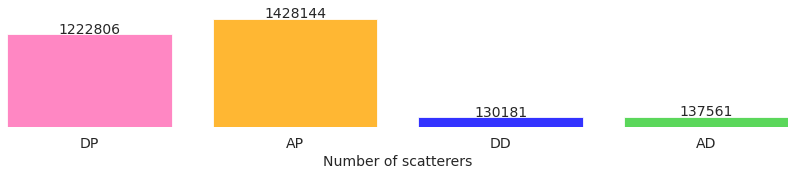

In [9]:
colors = ['hotpink','orange','blue','limegreen']
AllDatasets.DATASET = pd.Categorical(AllDatasets.DATASET,categories= ['DP','AP','DD','AD'])
AllDatasets=AllDatasets.sort_values('DATASET').copy()

group = AllDatasets.groupby(['DATASET']).agg({'V_LOS': 'count'})

fig1, ax = plt.subplots(figsize=(14,2))

bars = ax.bar(group.index,group['V_LOS'],color=colors, alpha=0.8)


ax=removeTopRightFrame(ax)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([]);

for bar in bars:
		ax.text(
		bar.get_x() + bar.get_width() / 2,
		bar.get_height()+9000,
		round(bar.get_height(), 3),
		horizontalalignment='center'
	)
        
ax.set_xlabel('Number of scatterers');
plt.margins(0,0)

fig1.savefig('Maps_Graph/GMAnalysis/'+ 'GMRecordNumbers' + '.png', dpi=400, bbox_inches = 'tight',
    pad_inches = 0)




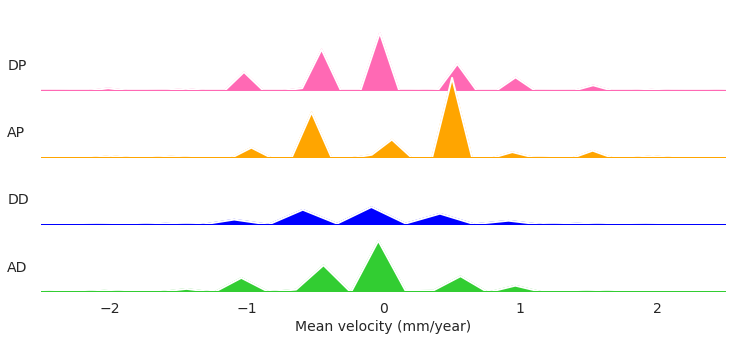

In [10]:
g = sns.FacetGrid(AllDatasets, row="DATASET", hue="DATASET", aspect=8, height=1.3,xlim=(-2.5,2.5), palette=colors, sharex=True)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'V_LOS', bw_adjust=.7, fill=True, alpha=1, linewidth=1.5, common_norm=False)
g.map(sns.kdeplot, "V_LOS", color="w", lw=2, bw_adjust=.7)
g.map(plt.axhline, y=0, lw=2)
    
#STYLE------------------------------------------------------
g.map(label, "V_LOS") 
g.set_xlabels('Mean velocity (mm/year)')
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.2) #it matters where is placed!and it needs the right stype sns
    
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.savefig('Maps_Graph/GMAnalysis/'+'MeanGeneralVelocity' +'.png', dpi=200, bbox_inches='tight')

# End preanalysis ----------------------------------------------------------------------

# DEscription----------------------------

In [72]:
def getTwoPointsNearInSpace():

    f = 'Data/Rheticus/' + '02-orb146_PS.csv'
    
    df = pd.read_csv(f, delimiter = ',')
    
    df= df[df['FID'].isin([462471,432169])].loc[:, 'DL20150425' :]
    df.columns= df.columns.str.replace('DL', '')
    df = df.T
    df.index= pd.to_datetime(df.index, format="%Y%m%d")
    
    return df

def getGraphTwoPoints():
    
    dfTwoPoints=getTwoPointsNearInSpace()
    
    fig1, ax  = plt.subplots(figsize=(14,6))

    ax=dfTwoPoints.plot(ax=ax, marker='o', alpha=0.7, linewidth=5,ms=8,color=['#1C7785','#E8A5A6'])

    ax = removeTopRightFrame(ax)
    ax.legend(ncol=4, facecolor='white',fontsize=14)
    plt.xticks(rotation=0,horizontalalignment='center')

    ax.set_ylabel("Ground level (mm)")
    ax.set_xlabel("Date");

    fig1.savefig('Maps_Graph/GMAnalysis/'+'TwoPointsGroundLevel' +'.png', dpi=200, bbox_inches='tight')


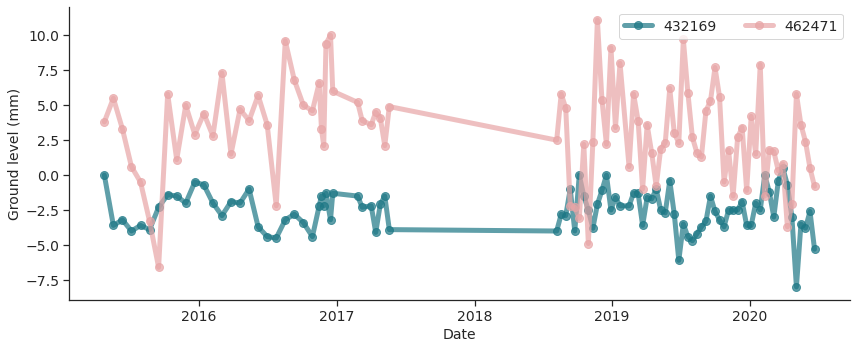

In [73]:
getGraphTwoPoints()

In [117]:
fComp= getComparisonPipeForFailurePipes()

Number of relationships between failed and non failed pipes from GIS 9327148
Number of failed pipes with a non failed connected pipe from GIS 9097
Number of filtered (mat,diam,len) relationships Failed-NON F 122373
Final number of failed pipes with a non failed connected pipe 6948


Number of  FID_NONFailedPipes_Buff15m  with points associated 91978
Number of  FID_FailedPipes_Buff15m  with points associated 3433
failed_UNIQUE  5523 from  6035
unfailed_UNIQUE  34090 from  123130
Number of scatterers used  34575
Size before fail 3433
Size before unfail 91978
Size after fail 3328
Size after unfail 2223
            Failed
count  3328.000000
mean      1.764423
std       1.141257
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max      17.000000
          Unfailed
count  2223.000000
mean      2.910031
std      59.338371
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max    2799.000000


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Number of  FID_NONFailedPipes_Buff15m  with points associated 327611
Number of  FID_FailedPipes_Buff15m  with points associated 7009
failed_UNIQUE  50540 from  54047
unfailed_UNIQUE  374722 from  1284927
Number of scatterers used  380178
Size before fail 7009
Size before unfail 327611
Size after fail 6771
Size after unfail 4792
            Failed
count  6771.000000
mean      7.711121
std       8.876445
min       1.000000
25%       2.000000
50%       5.000000
75%      10.000000
max     173.000000
           Unfailed
count   4792.000000
mean      13.513982
std      410.396584
min        1.000000
25%        2.000000
50%        5.000000
75%       10.000000
max    28411.000000
Number of  FID_NONFailedPipes_Buff15m  with points associated 98132
Number of  FID_FailedPipes_Buff15m  with points associated 3638
failed_UNIQUE  5962 from  6472
unfailed_UNIQUE  35782 from  132982
Number of scatterers used  36261
Size before fail 3638
Size before unfail 98132
Size after fail 3536
Size after unfail 2

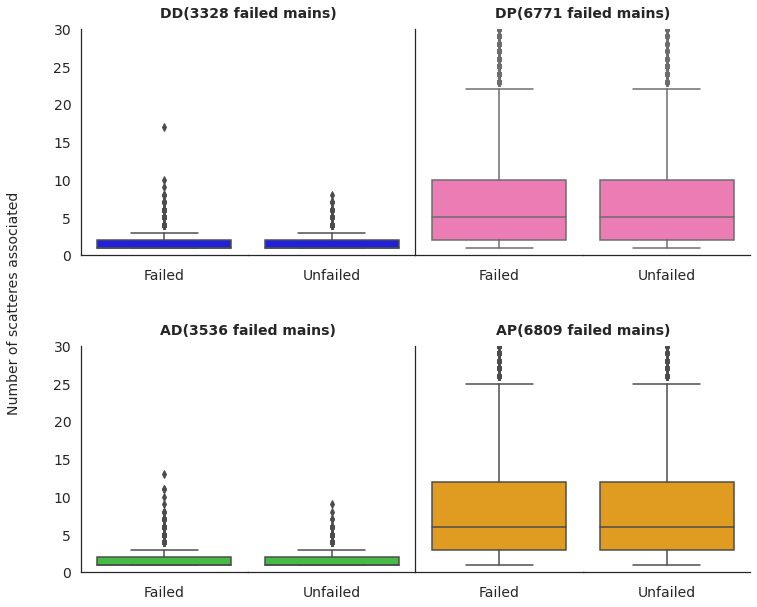

In [154]:
def getPointsUsed(fileBufferInterceptNON,fbufferNON,columnBuffNON,
								fileBufferIntercept,fbuffer,columnBuff,dateF,columnPoints,filePoints, date2String, name,
								filePoints2 = None, fileIntNONSouth = None, fileIntSouth = None, columnSouth = None):

	orb146_I_BuffNON = getPipeGMPointsRelation(fileBufferInterceptNON,fbufferNON,columnBuffNON,fileIntNONSouth,columnPoints, columnSouth)
	orb146_I_Buff = getPipeGMPointsRelation(fileBufferIntercept,fbuffer,columnBuff,fileIntSouth,columnPoints,columnSouth)

	return orb146_I_BuffNON , orb146_I_Buff 


    
def gMDistance(df, failedPipesRelation):

	dateF = dt2.datetime(2015, 4, 1)
	dateF2 = dt2.datetime(2015, 4, 9)
	folder = 'Data/Rheticus/'

	fbufferNON = folder + '09-NONFailedPBuff.csv'
	columnBuffNON = 'FID_NONFailedPipes_Buff15m'
	fbuffer = folder + '10-FailedPBuff.csv'
	columnBuff =  'FID_FailedPipes_Buff15m'

	names = ['orb_146_DS', 'orb_146_PS', 'orb_081_DS', 'orb_081_PS']
	colors = ['blue','hotpink','limegreen','orange']
	nameLabel=['DD', 'DP', 'AD', 'AP'] 

	filesPoints = ['01-orb146_DS.csv', '02-orb146_PS.csv', '03-orb081_DSNORD.csv', '04-orb081_DSSUD.csv', '05-orb081_PSNORD.csv', '06-orb081_PSSUD.csv']
	secondDates = ['DL20150425', 'DL20150425', 'DL20150503', 'DL20150503', 'DL20150503', 'DL20150503']
	firstDates = [dateF, dateF, dateF2, dateF2, dateF2, dateF2]

	filesBuffersFailed = ['12-FailedPBuff_I_orb146DS.csv', '14-FailedPBuff_I_orb146PS.csv', '17-FailedPBuff_I_081DSNORD.csv', '18-FailedPBuff_I_081DSSUD.csv', 
						'21-FailedPBuff_I_081PSNORD.csv','22-FailedPBuff_I_081PSSUD.csv']

	filesBuffNONFailed = ['11-NONFailedPBuff_I_orb146DS.csv', '13-NONFailedPBuff_I_orb146PS.csv', '15-NONFailedPBuff_I_081DSNORD.csv', '16-NONFailedPBuff_I_081DSSUD.csv',
							'19-NONFailedPBuff_I_081PSNORD.csv', '20-NONFailedPBuff_I_081PSSUD.csv']

	columnsPoints = ['FID_orb146_DS', 'FID_orb146_PS', 'FID_orb081_DSNORD', 'FID_orb081_DSSUD','FID_orb081_PSNORD', 'FID_orb081_PSSUD'] 

	pointsVSFails = []

	dateString = dt.now().strftime("%d-%b(%H:%M)")
    
	fig1, [[ax,ax1,ax2,ax3],[ax4,ax5,ax6,ax7]] = plt.subplots(2,4,figsize=(12,10),sharey=True)
	fig1.text(0.04, 0.5, 'Number of scatteres associated', va='center', rotation='vertical')
	plt.subplots_adjust(wspace=0,hspace=0.4)

	i = 0
	for sf,axs,c,n in zip([0,1,2,4],[[ax,ax1],[ax2,ax3],[ax4,ax5],[ax6,ax7]],colors,nameLabel): 

		if sf < 2:

			#add ,repe at the end 
			unFail, failed = getPointsUsed(folder + filesBuffNONFailed[sf],fbufferNON,columnBuffNON, 
																		folder + filesBuffersFailed[sf], fbuffer,columnBuff,firstDates[sf],columnsPoints[sf], 
																		folder + filesPoints[sf], secondDates[sf], names[i])
			col = columnsPoints[sf]
            
		else :
			#add ,repe at the end 
			unFail, failed = getPointsUsed(folder + filesBuffNONFailed[sf],fbufferNON,columnBuffNON, folder + filesBuffersFailed[sf],
									fbuffer, columnBuff,firstDates[sf],columnsPoints[sf], folder + filesPoints[sf], secondDates[sf], names[i], 
									folder + filesPoints[sf+1], folder + filesBuffNONFailed[sf+1], folder + filesBuffersFailed[sf+1],columnsPoints[sf+1])
			col = (columnsPoints[sf])[:-4]
            
		uniqueFailSc= failed[col].unique().tolist()             
		uniqueUnFailSc= unFail[col].unique().tolist()  
		print("failed_UNIQUE " , len(uniqueFailSc), "from ", failed.shape[0])
		print("unfailed_UNIQUE " , len(uniqueUnFailSc),"from ", unFail.shape[0])
        
		uniqueFailSc.extend(uniqueUnFailSc)
		numScat= set(uniqueFailSc)    
		print("Number of scatterers used ", len(numScat))

            
		countUnFail=unFail.reset_index().groupby([COMPKEY]).agg({col: 'count'}).copy()
		countFail=failed.reset_index().groupby([COMPKEY]).agg({col: 'count'}).copy()
        
		print("Size before fail", countFail.shape[0])
		print("Size before unfail", countUnFail.shape[0])
        
		countFail=countFail[countFail.index.isin(df[COMPKEY].unique())].copy()
        
		failRel=failedPipesRelation[failedPipesRelation.index.isin(df[COMPKEY].unique())].copy()
		countUnFail=countUnFail[countUnFail.index.isin(failRel['COMPKEY_NotFails'].unique())].copy()
        
		print("Size after fail", countFail.shape[0])
		print("Size after unfail", countUnFail.shape[0])
        
		countFail.rename(columns={col:'Failed'}, inplace= True)
		countUnFail.rename(columns={col:'Unfailed'}, inplace= True)
		print(countFail.describe())
		print(countUnFail.describe())       
        
		sns.boxplot(ax=axs[0],y=countFail['Failed'],color=c)
		sns.boxplot(ax=axs[1],y=countUnFail['Unfailed'],color=c)
		sns.despine(ax=axs[0])
		sns.despine(ax=axs[1],left=True)
		axs[0].set_ylim(0,30)
		axs[1].set_ylim(0,30)
		axs[0].set_ylabel("")
		axs[1].set_ylabel("")
		axs[0].set_xlabel("Failed")
		axs[1].set_xlabel("Unfailed")
		axs[0].text(0.5, 32, n + "("+ str(countFail.shape[0]) +" failed mains)", horizontalalignment='center', verticalalignment='center',weight='bold')
    
		i += 1
        
	fig1.savefig('Maps_Graph/GMAnalysis/'+'NumberOfPointsAsso' +'.png', dpi=200, bbox_inches='tight')
        
    
gMDistance(failuresPMaterials.copy(),fComp)



# End of description -------------------------------------------------------------------

In [12]:
def calculateStatsPerMaterial(resultMate, cri,criNON):
    
    resultMateFil= resultMate[resultMate[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    
    dfNONAN= resultMateFil.dropna()
    res= smS.ttest_ind(dfNONAN[cri],dfNONAN[criNON],usevar='unequal')
    
    print("P-value for all:")
    #display(res)
    print("Mean criteria: failed ", dfNONAN[cri].mean()," control ",dfNONAN[criNON].mean())
    
    criteria = resultMateFil[["MATERIAL", cri]]
    criteria['PipeType'] = 'Failed'
    criteriaNON = resultMateFil[["MATERIAL", criNON]]
    criteriaNON['PipeType'] = 'Unfailed'
    criteriaNON.rename(columns={criNON:cri}, inplace= True)
     
    criteria = criteria.append(criteriaNON)
    assert resultMateFil.shape[0] == (0.5*criteria.shape[0])
    
    for m in MATERIALS_PREDOMI:
        
        dfM= resultMateFil[resultMateFil[MATERIAL]== m].copy()
        dfMN= dfM.dropna()
        resM= smS.ttest_ind(dfMN[cri],dfMN[criNON],usevar='unequal')
        
        #print("P-value for ", m, " ", dfMN.shape[0])
        #display(resM)
    
    return criteria
    
    
def analyseResults(wPipes):

    dateString = '17-Sep(07:50)'
    names = ['orb_146_DS', 'orb_146_PS', 'orb_081_DS', 'orb_081_PS']
    colsGM = ['AbsMov','Max-Min','maxVel','meanVel']
    labelsGM = ["Maximum total", 'Maximum max-min', 'Maximum max velocity','Maximum mean velocity']
    
    for name in names:
        
        fig1, [[ax,ax1],[ax2,ax3]] = plt.subplots(2,2,figsize=(12,10))
        print(name)

        for i,cri,axi,c in zip(['','2','3','4'],colsGM, [ax,ax1,ax2,ax3],labelsGM):
    
            #read the results
            fResultsCrit = 'Output/'+ dateString+ '/TestCrite'+ i + name + dateString+'.csv'
            resultsCrit = pd.read_csv(fResultsCrit, delimiter = ',', index_col=[WONO])
        
            #adds the column material
            criNON = cri + "NONF"
            resultMate= resultsCrit.join(wPipes, on=COMPKEY)[[cri,criNON,"MATERIAL"]].copy()
            assert resultsCrit.shape[0] == resultMate.shape[0]
            
            #resultMate['Shape_Leng'].describe()
            
            #remove non predominan materials and calculates p values
            datasetsMod= calculateStatsPerMaterial(resultMate.copy(),cri,criNON)
            
            sns.violinplot(data=datasetsMod, x=cri, y="PipeType", split=True, 
                   inner="quart", linewidth=1, ax=axi, palette='Set2_r')
            
            axi.legend().remove()
            axi = removeTopRightFrame(axi)
            axi.spines['left'].set_visible(False)
            axi.set_ylabel('')
            axi.set_xlabel(c)
            
            for l in axi.lines:
                l.set_linestyle('-')
                l.set_color('black')
            
        fig1.savefig('Maps_Graph/GMAnalysis/'+'ViolinCriteria'+name +'.png', dpi=200, bbox_inches='tight')
     

No handles with labels found to put in legend.


orb_146_DS
P-value for all:
Mean criteria: failed  8.77770642201835  control  8.383853211009175
P-value for all:
Mean criteria: failed  2.8729357798165136  control  2.779724770642202


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


P-value for all:
Mean criteria: failed  0.17181698900735598  control  0.16596684987740035
P-value for all:
Mean criteria: failed  0.06938652766749097  control  0.06744957117864228


No handles with labels found to put in legend.


orb_146_PS
P-value for all:
Mean criteria: failed  30.831971345184403  control  31.942080127354735
P-value for all:


No handles with labels found to put in legend.


Mean criteria: failed  10.636057309631203  control  10.89349960201645
P-value for all:
Mean criteria: failed  0.7124155828686208  control  0.7214737838975037


No handles with labels found to put in legend.
No handles with labels found to put in legend.


P-value for all:
Mean criteria: failed  0.2602858263170183  control  0.266239516400147


No handles with labels found to put in legend.


orb_081_DS
P-value for all:
Mean criteria: failed  11.36891156462585  control  11.398503401360543
P-value for all:
Mean criteria: failed  3.514353741496599  control  3.519931972789115


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


P-value for all:
Mean criteria: failed  0.22038784958427815  control  0.21721608087679514
P-value for all:
Mean criteria: failed  0.08298193515668005  control  0.08270874825445404


No handles with labels found to put in legend.


orb_081_PS
P-value for all:
Mean criteria: failed  41.03837357052097  control  40.99570097416349


No handles with labels found to put in legend.


P-value for all:
Mean criteria: failed  12.967005506141465  control  12.91126641253706
P-value for all:
Mean criteria: failed  0.8743483516871382  control  0.8778043966774907


No handles with labels found to put in legend.
No handles with labels found to put in legend.


P-value for all:
Mean criteria: failed  0.30168565979943135  control  0.30228527224639173


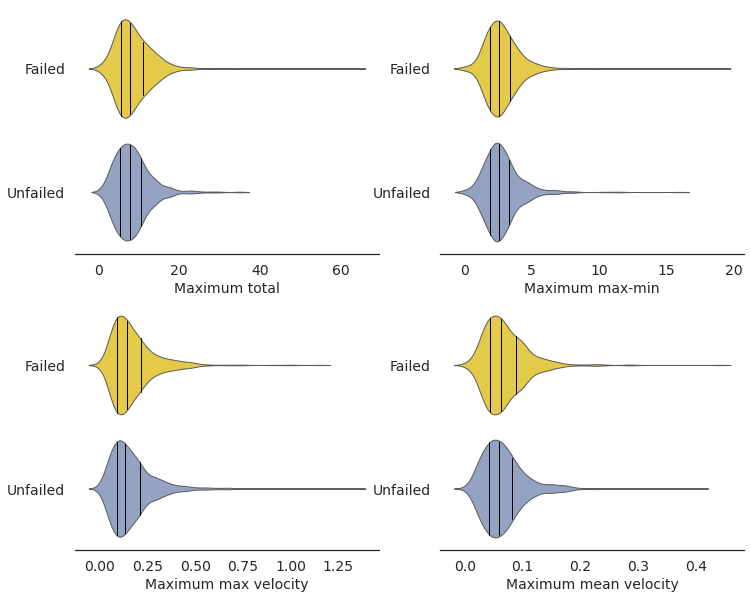

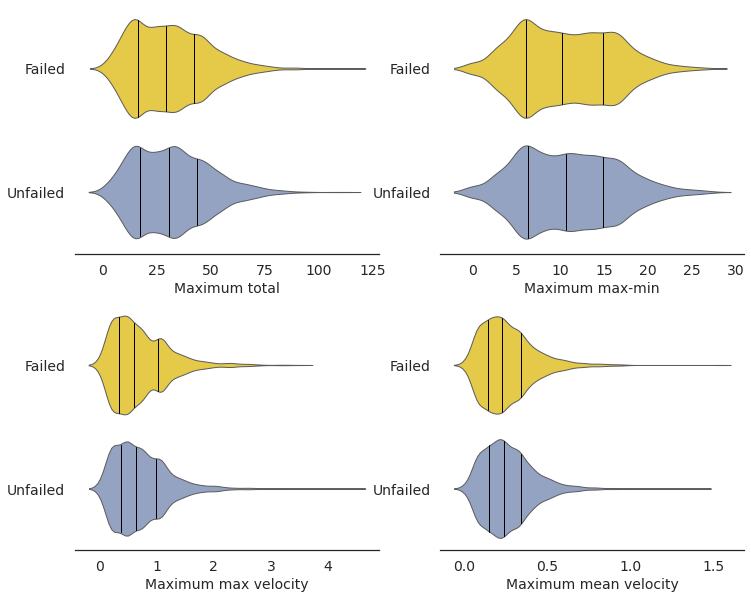

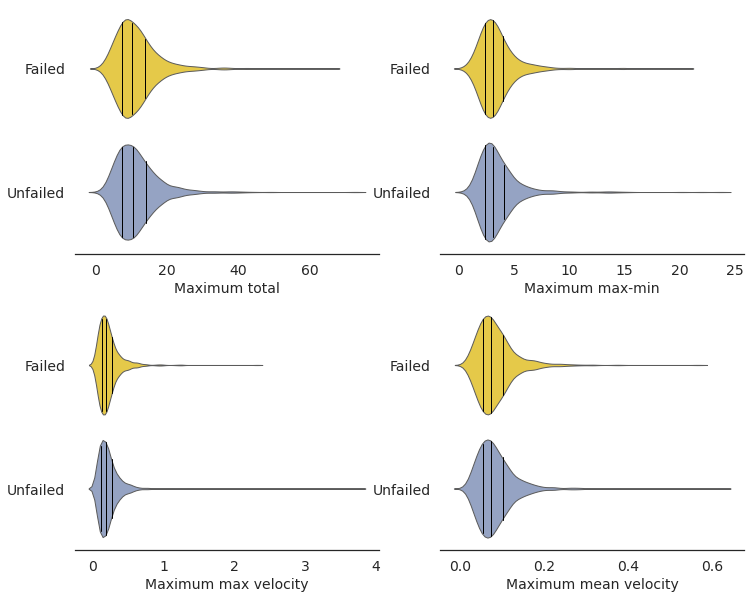

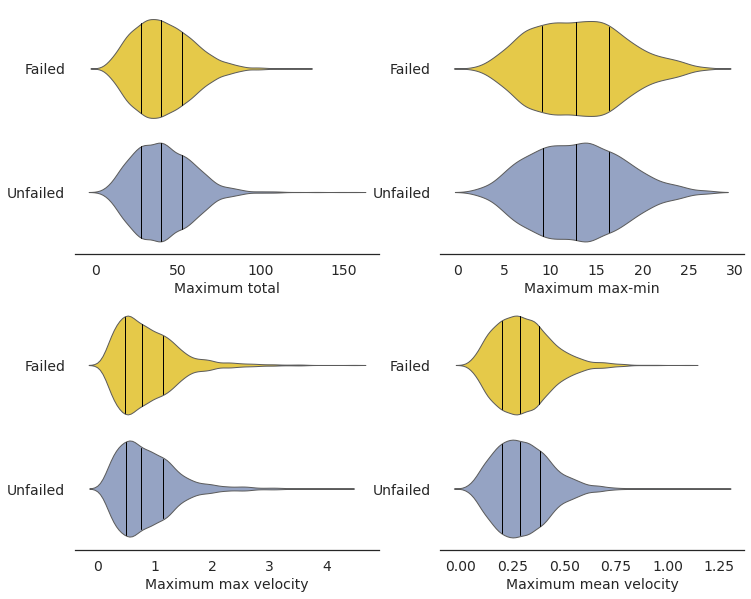

In [13]:
analyseResults(wPipesGISNfailures)

orb_146_DS
P-value for all:


(1.9454147039071508, 0.05185554830748213, 2145.3849546898023)

P-value for  AC   540


(0.15094494095468788, 0.880047391374813, 1077.9048779832733)

P-value for  PVC   264


(2.23971202655618, 0.025592172147765452, 454.7050579576296)

P-value for  CI   64


(-0.2418085783228779, 0.8093684002824793, 112.5803412357463)

P-value for  PE   222


(1.3832865534288263, 0.16727583443886318, 441.6651882902792)

No handles with labels found to put in legend.


P-value for all:


(1.4393324884269767, 0.15020218482177444, 2145.987825863265)

P-value for  AC   540


(-0.6779715509363773, 0.4979356061012299, 1075.1607536596205)

P-value for  PVC   264


(2.2444155098063887, 0.025276635346089052, 463.5919668989295)

P-value for  CI   64


(0.020485879466473948, 0.9836898574720371, 119.79883758933495)

P-value for  PE   222


(1.1703011235635734, 0.2425119670242651, 440.9182252032918)

No handles with labels found to put in legend.


P-value for all:


(1.1413199327617414, 0.2538622935463444, 2177.7623010341445)

P-value for  AC   540


(0.282833352317873, 0.7773588896392369, 1077.9074221841024)

P-value for  PVC   264


(1.5390333365122433, 0.12440023967198696, 523.5983421400863)

P-value for  CI   64


(-1.1529071448599868, 0.2520698977955045, 88.01878448733169)

P-value for  PE   222


(0.7576421859651478, 0.4490694605561286, 441.4357071890488)

No handles with labels found to put in legend.


P-value for all:


(1.137054839869469, 0.25564075707874756, 2172.5012386759654)

P-value for  AC   540


(-0.08885745657007357, 0.9292118651748433, 1067.2604199629714)

P-value for  PVC   264


(1.917342321324988, 0.055759000122578985, 504.3707777547554)

P-value for  CI   64


(-0.934456749752455, 0.3528347919511795, 81.32230770446313)

P-value for  PE   222


(0.9288652721843512, 0.3534682648853742, 439.93812610009246)

No handles with labels found to put in legend.


orb_146_PS
P-value for all:


(-2.819654812074583, 0.004820088216400274, 7532.999965562222)

P-value for  AC   1953


(-1.0007494006770994, 0.3170100022810896, 3903.879509482652)

P-value for  PVC   900


(-1.295454262327122, 0.1953300004143152, 1796.5167279580041)

P-value for  CI   323


(-1.5152668139560295, 0.1301973516000441, 641.5723422147748)

P-value for  PE   593


(-2.624402531699929, 0.008792263647960343, 1179.3258304422618)

No handles with labels found to put in legend.


P-value for all:


(-2.058745954872271, 0.03955288146745533, 7534.617137864068)

P-value for  AC   1953


(-0.344168435918483, 0.7307381546744767, 3903.9947820960733)

P-value for  PVC   900


(-0.8253829457842828, 0.409263712249229, 1797.949286320913)

P-value for  CI   323


(-1.6583355060880052, 0.09773818224459649, 642.0603474455143)

P-value for  PE   593


(-2.292978471515581, 0.02202417779049219, 1182.0609025016904)

No handles with labels found to put in legend.


P-value for all:


(-0.7972382074365898, 0.42533784245270956, 7528.4853169613725)

P-value for  AC   1953


(0.28585729094847634, 0.775002651892055, 3888.7168509286125)

P-value for  PVC   900


(-0.31493918306080854, 0.7528443796939183, 1797.751880505947)

P-value for  CI   323


(-0.8859850391887154, 0.3759564919037528, 643.6186629315094)

P-value for  PE   593


(-1.464615556056963, 0.14329131915785917, 1183.9091807393559)

No handles with labels found to put in legend.


P-value for all:


(-1.6454674027594127, 0.09991517676149031, 7533.514664088356)

P-value for  AC   1953


(0.17708633728392423, 0.8594497913836392, 3890.6678269551826)

P-value for  PVC   900


(-1.058037313643334, 0.29018055659716074, 1797.9804446146143)

P-value for  CI   323


(-1.5170179411829416, 0.1297539592334923, 642.5545076600894)

P-value for  PE   593


(-2.153603796105789, 0.03147365016066121, 1178.0842274544982)

No handles with labels found to put in legend.


orb_081_DS
P-value for all:


(-0.12965330473804465, 0.8968496053992514, 2937.3192985646565)

P-value for  AC   713


(-0.09787522160299016, 0.9220451947318089, 1419.384509909605)

P-value for  PVC   382


(-1.486043830905332, 0.13769738010635296, 733.1904137354832)

P-value for  CI   106


(-0.5516411084607596, 0.5817923151211347, 205.94737629136776)

P-value for  PE   269


(1.8104554809119409, 0.07081334192562991, 510.1806202024542)

No handles with labels found to put in legend.


P-value for all:


(-0.07433114932069854, 0.9407519545102875, 2936.704226869215)

P-value for  AC   713


(-0.4305129653105953, 0.6668884892033302, 1406.6689763632567)

P-value for  PVC   382


(-1.1017354028884976, 0.2709486280680749, 712.7326538973663)

P-value for  CI   106


(-0.42819304053495255, 0.668954146885081, 207.75748508025742)

P-value for  PE   269


(2.1022929421783174, 0.0360265041440652, 500.5848374870745)

No handles with labels found to put in legend.


P-value for all:


(0.5156918791363722, 0.6061085580914871, 2928.326942442082)

P-value for  AC   713


(0.5726900301292094, 0.5669455974266584, 1414.6160160506997)

P-value for  PVC   382


(-0.8328648416160883, 0.40520561054329896, 698.5665154511732)

P-value for  CI   106


(-0.17787383351059555, 0.8589962341896947, 206.72737308628234)

P-value for  PE   269


(1.7071819500702152, 0.08837913534100013, 525.3238401332501)

No handles with labels found to put in legend.


P-value for all:


(0.16028245794996648, 0.872669599338696, 2936.9818025270233)

P-value for  AC   713


(0.19487654280642058, 0.8455174707879276, 1420.250160706165)

P-value for  PVC   382


(-1.2203993426436652, 0.222695142247823, 753.8369222541052)

P-value for  CI   106


(-0.5498849616559086, 0.5830150704924915, 198.94560929594667)

P-value for  PE   269


(1.795262365329477, 0.07319313748242262, 519.3851296683675)

No handles with labels found to put in legend.


orb_081_PS
P-value for all:


(0.11752845559825574, 0.9064437959931064, 9441.373452910813)

P-value for  AC   2434


(0.1592736583487713, 0.8734598844211796, 4865.369056628682)

P-value for  PVC   1140


(-0.6167397701686205, 0.5374680174001631, 2277.9097111381343)

P-value for  CI   408


(1.4550733425398021, 0.14603451643193013, 813.9069861936529)

P-value for  PE   740


(-0.26739944536434773, 0.7891989417989582, 1477.6809228691066)

No handles with labels found to put in legend.


P-value for all:


(0.5473741496585176, 0.5841346487059035, 9441.899484815378)

P-value for  AC   2434


(-0.2135645600836268, 0.8308955862994997, 4865.827420053559)

P-value for  PVC   1140


(-0.012719344190266348, 0.9898528194461749, 2277.230968194826)

P-value for  CI   408


(1.9505364917168053, 0.05145549476320469, 812.9620471581533)

P-value for  PE   740


(0.36355606351702124, 0.7162415382196807, 1477.887892050257)

No handles with labels found to put in legend.


P-value for all:


(-0.30952132789039616, 0.7569318216610433, 9441.078443460594)

P-value for  AC   2434


(-0.17736352351557638, 0.8592302393698077, 4865.874189571)

P-value for  PVC   1140


(-0.8575992137287519, 0.3912040705316947, 2276.843262559264)

P-value for  CI   408


(0.22355487696177234, 0.8231611135802337, 794.94909233556)

P-value for  PE   740


(0.4328570656678692, 0.6651819142110131, 1474.5753855953656)

No handles with labels found to put in legend.


P-value for all:


(-0.2109557125885867, 0.832926384008298, 9438.496255055516)

P-value for  AC   2434


(0.00669369290759394, 0.9946595200727308, 4865.586407641919)

P-value for  PVC   1140


(-0.7603147241912459, 0.44714520895061627, 2276.7502322764462)

P-value for  CI   408


(0.9917981963700295, 0.32159211953082584, 810.0996750632992)

P-value for  PE   740


(-0.32567808079062033, 0.7447140560940236, 1477.1669594265677)

No handles with labels found to put in legend.


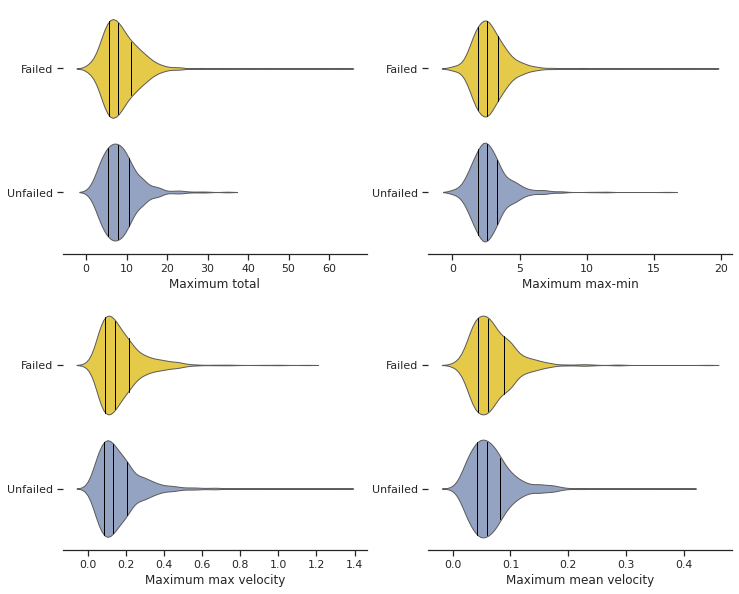

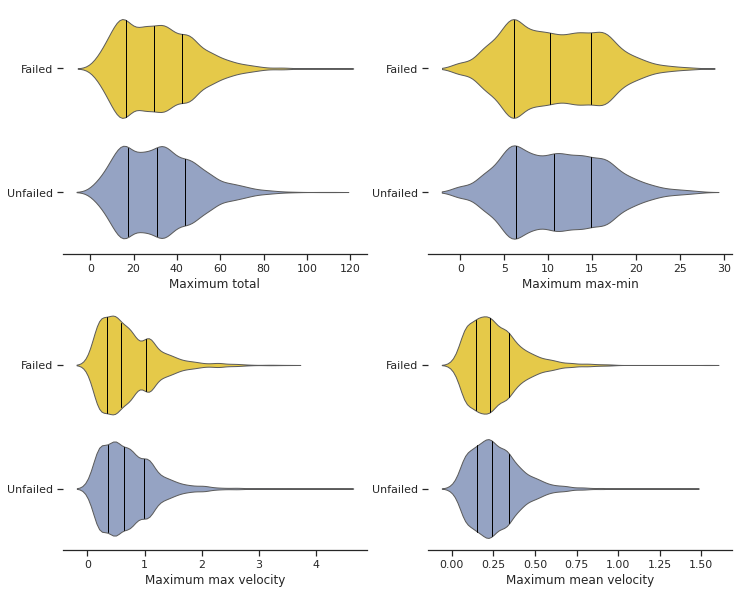

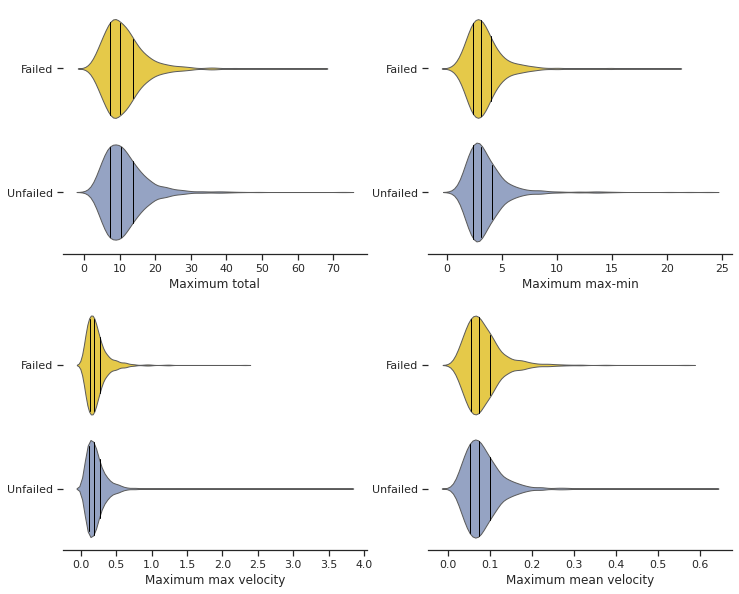

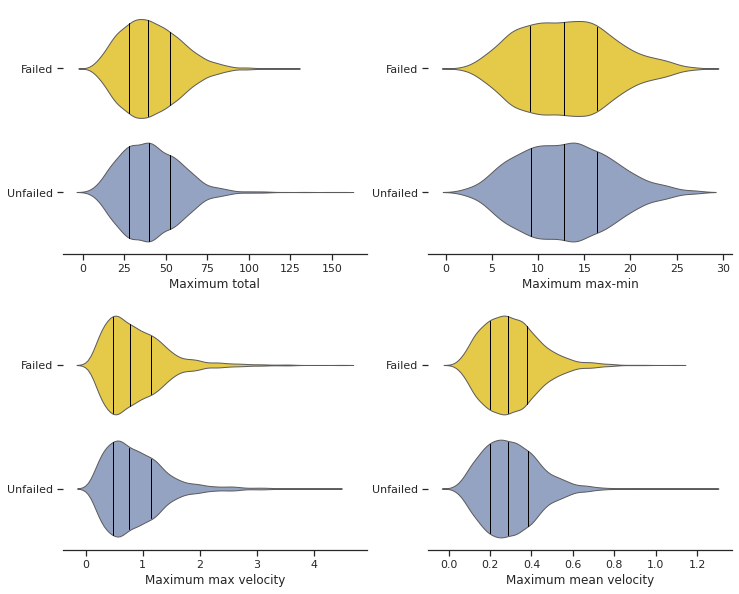

In [138]:
analyseResults(wPipesGISNfailures)

orb_146_DS


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


orb_146_PS


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


orb_081_DS


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


orb_081_PS


No handles with labels found to put in legend.
No handles with labels found to put in legend.


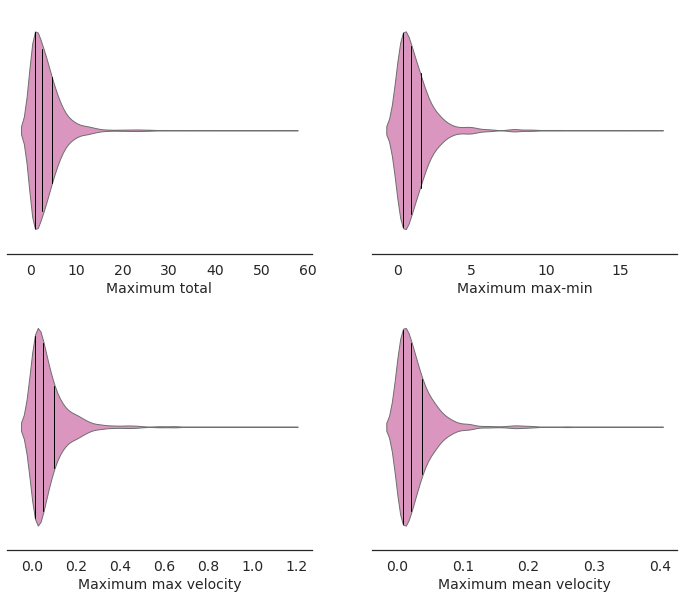

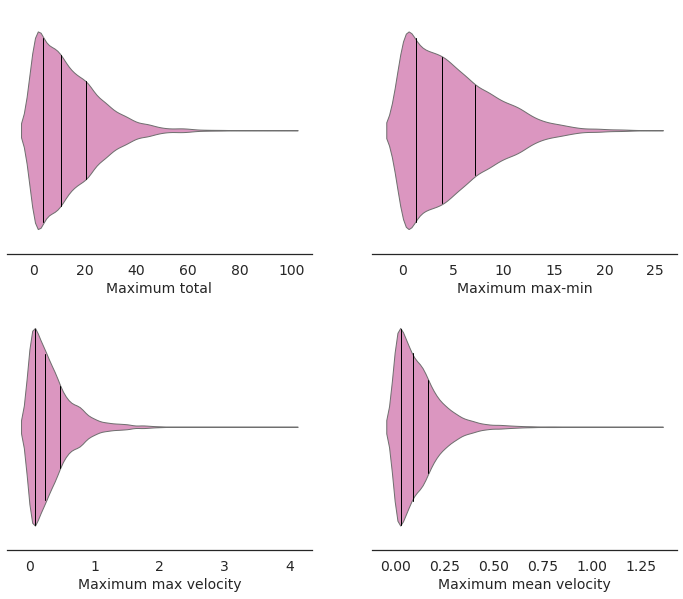

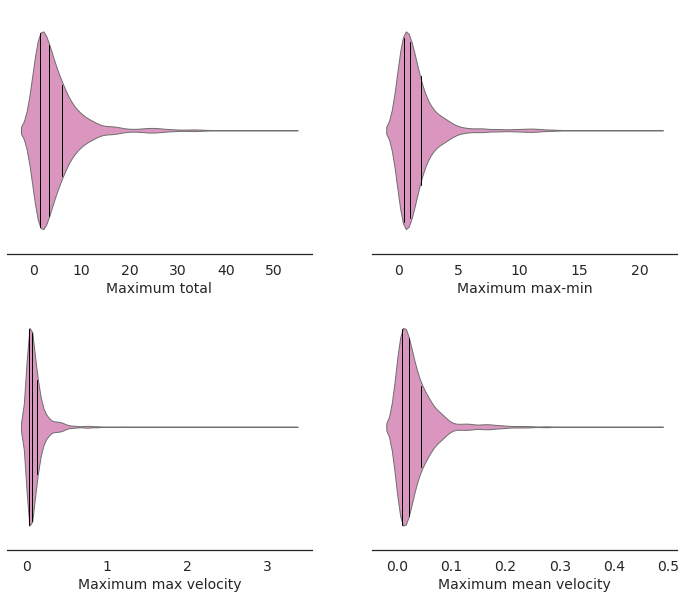

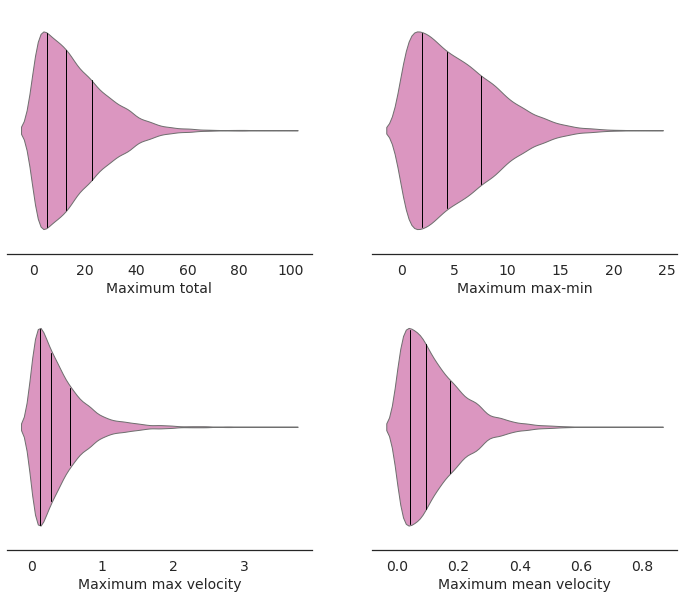

In [169]:
def analyseResultsDifferences(wPipes):

    dateString = '17-Sep(07:50)'
    names = ['orb_146_DS', 'orb_146_PS', 'orb_081_DS', 'orb_081_PS']
    colsGM = ['AbsMov','Max-Min','maxVel','meanVel']
    labelsGM = ["Maximum total", 'Maximum max-min', 'Maximum max velocity','Maximum mean velocity']
    
    for name in names:
        
        fig1, [[ax,ax1],[ax2,ax3]] = plt.subplots(2,2,figsize=(12,10))
        print(name)

        for i,cri,axi,c in zip(['','2','3','4'],colsGM, [ax,ax1,ax2,ax3],labelsGM):
    
            #read the results
            fResultsCrit = 'Output/'+ dateString+ '/TestCrite'+ i + name + dateString+'.csv'
            resultsCrit = pd.read_csv(fResultsCrit, delimiter = ',', index_col=[WONO])
        
            #adds the column material
            criNON = cri + "NONF"
            resultMate= resultsCrit.join(wPipes, on=COMPKEY)[[cri,criNON,"MATERIAL"]].copy()
            assert resultsCrit.shape[0] == resultMate.shape[0]
            
            #remove non predominan materials and calculates p values
            resultMate['Diff']= (resultMate[cri]-resultMate[criNON]).abs()
            resultMateFil= resultMate[resultMate[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    
            datasetsMod= resultMateFil.dropna()
    
            
            sns.violinplot(data=datasetsMod, x='Diff', inner="quart", linewidth=1, ax=axi, palette='Set2_r')
            
            axi.legend().remove()
            axi = removeTopRightFrame(axi)
            axi.spines['left'].set_visible(False)
            axi.set_ylabel('')
            axi.set_xlabel(c)
            
            for l in axi.lines:
                l.set_linestyle('-')
                l.set_color('black')
            
        #fig1.savefig('Maps_Graph/GMAnalysis/'+'ViolinCriteria'+name +'.png', dpi=200, bbox_inches='tight')
        
analyseResultsDifferences(predoMaterials)

In [48]:
sns.set_theme(style="ticks")

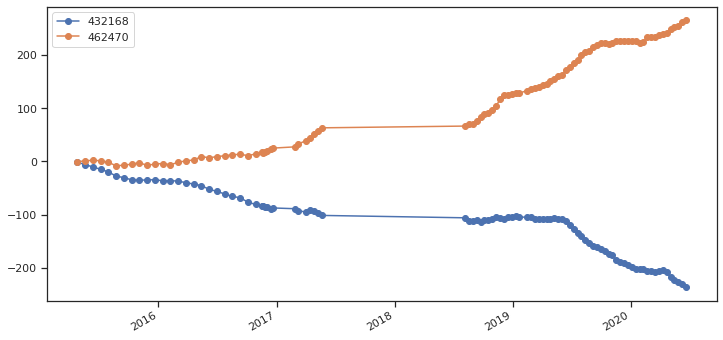

In [31]:
fig1, ax  = plt.subplots(figsize=(12,6))

ax=dfCumSum.plot(ax=ax, marker='o')
#ax.set_xlim('2017-02-25', '2018-11-11')


In [159]:
f = 'Data/Rheticus/' + '02-orb146_PS.csv'
    
df = pd.read_csv(f, delimiter = ',')
    
df= df[df['FID'].isin([462471,432169])]
display(df.loc[:, 'H_ELL' :])
print("differences in incidence degrees ", 34.394-34.388)

,H_ELL,H_STDDEV,H_AUX_DEM,COH,INC_ANG,HEAD_ANG,V_LOS,V_LOS_STD,DL20150401,DL20150425,...,DL20200305,DL20200317,DL20200329,DL20200410,DL20200422,DL20200504,DL20200516,DL20200528,DL20200609,DL20200621
432169,93.0,1.3,-2.5,0.95,34.388,15.924,0.0,0.09,0,0.0,...,-3.0,-0.4,0.5,-0.7,-3.0,-8.0,-3.5,-3.8,-2.6,-5.3
462471,100.5,3.0,-1.0,0.75,34.394,15.925,-0.5,0.21,0,3.8,...,1.7,0.3,0.8,-3.7,-2.1,5.8,3.6,2.4,0.5,-0.8


differences in incidence degrees  0.006000000000000227


In [158]:
print("percentage of scatterers used with each dataset")
display(34575/130181,380178/1222806,36261/137561,450103/1428144)

percentage of scatterers used with each dataset


0.26559175302079413

0.310906227152958

0.2635994213476203

0.31516639778621763